# Классификация статей на arXiv: NLP vs CV

## Проблема


На arXiv ежедневно публикуется множество статей. Исследователям приходится вручную отслеживать и находить релевантные статьи в своих областях (NLP или CV). Идея - разработать модель, которая будет присваивать входящим статьям arXiv метку NLP (Computation and Language) или CV (Computer Vision and Pattern Recognition) на основе текста аннотаций.

In [54]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.autonotebook import tqdm

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nutik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
stop_words = set(stopwords.words("english"))

In [12]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [13]:
random_state = 42

## Загрузка, предобработка и анализ данных

In [16]:
sharing_url = "https://drive.google.com/file/d/1tYOvMI4Ew-kJK0CWi-laXJw_t9lgNh9U/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)

In [17]:
df.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9904004v1,Mixing Metaphors,Computation and Language (Natural Language Pro...,cs.CL,4/12/99,4/12/99,"['Mark Lee', 'John Barnden']",'Mark Lee',Mixed metaphors have been neglected in recent ...,90
1,cs-9906006v2,Learning Efficient Disambiguation,Computation and Language (Natural Language Pro...,cs.CL,6/2/99,6/3/99,"[""Khalil Sima'an""]","""Khalil Sima'an""",This dissertation analyses the computational p...,227
2,cs-9906019v2,Resolving Part-of-Speech Ambiguity in the Gree...,Computation and Language (Natural Language Pro...,cs.CL,6/22/99,6/30/99,"['G. Petasis', 'G. Paliouras', 'V. Karkaletsis...",'G. Petasis',This article investigates the use of Transform...,85
3,cs-9907026v1,Mixing representation levels: The hybrid appro...,Computation and Language (Natural Language Pro...,cs.CL,7/16/99,7/16/99,"['Emanuele Pianta', 'Lucia M. Tovena']",'Emanuele Pianta',Natural language generation systems (NLG) map ...,124
4,cs-0001002v1,Minimum Description Length and Compositionality,Computation and Language (Natural Language Pro...,cs.CL,1/4/00,1/4/00,['Wlodek Zadrozny'],'Wlodek Zadrozny',We present a non-vacuous definition of composi...,113


В данных 9 категориальных признака и 1 числовой:

In [18]:
df.dtypes

id                    object
title                 object
category              object
category_code         object
published_date        object
updated_date          object
authors               object
first_author          object
summary               object
summary_word_count     int64
dtype: object

In [19]:
df.describe()

,summary_word_count
count,54259.000000
mean,161.806981
std,46.166047
min,5.000000
25%,130.000000
50%,160.000000
75%,192.000000
max,491.000000


Пропущенных значений нет

In [20]:
df.isna().any()

id                    False
title                 False
category              False
category_code         False
published_date        False
updated_date          False
authors               False
first_author          False
summary               False
summary_word_count    False
dtype: bool

Как устроены данные?

```id``` - идентификатор статьи на arXiv, не будет использоваться при анализе данных

```title``` - название статьи, содержит ключевые термины

```category``` и ```category_code``` - бинарная метка, она будет целевой переменной: cs.CL (класс 0) или cs.CV (класс 1)

```published_date``` и ```updated_date```: дата публикации

```authors``` - список всех авторов

```first_author``` - первый автор

```summary``` - аннотация статьи, главная переменная для анализа, будем использовать вместе с title

```summary_word_count``` - кол-во слов в аннотации


In [21]:
df["target"] = (df["category_code"] == "cs.CV").astype(int) # создаем столбец с целевой переменной
df.drop(["id", "category", "category_code"], axis=1, inplace=True) # удаляем лишние столбцы

In [22]:
df["published_date"] = pd.to_datetime(df["published_date"], format="%m/%d/%y") # преобразуем время в формат datetime
df["updated_date"] = pd.to_datetime(df["updated_date"], format="%m/%d/%y") # преобразуем время в формат datetime
df_sorted = df.sort_values(["published_date", "updated_date"]) # сортируем статьи от более ранних к более поздним

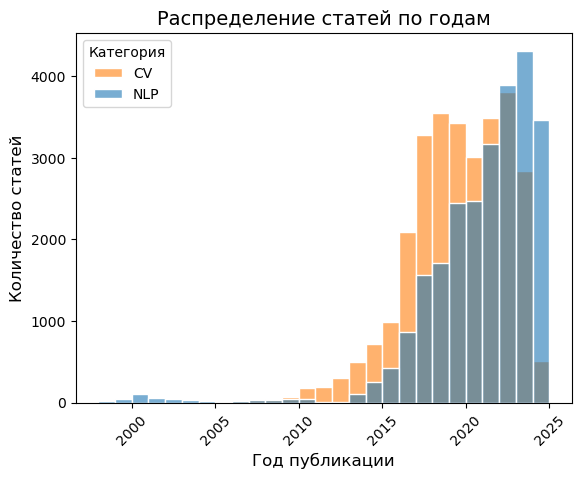

In [27]:
df["published_year"] = df["published_date"].dt.year

sns.histplot(
    data=df,
    x="published_year",
    hue="target",
    binwidth=1,
    alpha=0.6,
    edgecolor="white"
)

plt.title("Распределение статей по годам", fontsize=14)
plt.xlabel("Год публикации", fontsize=12)
plt.ylabel("Количество статей", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Категория", labels=["CV", "NLP"])
plt.show()

В NLP больше современных статей, чем в CV, особенно в последние 5 лет.

In [28]:
df.drop(["published_date", "updated_date", "published_year"], axis=1, inplace=True) # удаляем лишние столбцы
train_df = df.head(round(len(df) * 0.8))
test_df = df.tail(round(len(df) * 0.2))

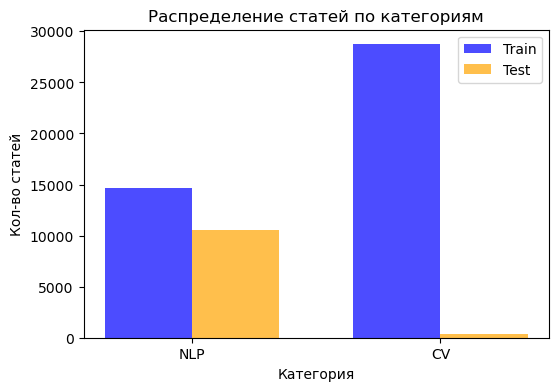

In [31]:
categories = ["NLP", "CV"]
train_counts = train_df["target"].value_counts().sort_index() # считаем целевую переменную 
test_counts = test_df["target"].value_counts().sort_index() # считаем тестовую переменную

x = np.arange(len(categories))
width = 0.35

# делаем график

plt.figure(figsize=(6, 4))
plt.title("Распределение статей по категориям", fontsize=12)

plt.bar(x - width/2, train_counts, width, label="Train", color="blue", alpha=0.7)
plt.bar(x + width/2, test_counts, width, label="Test", color="orange", alpha=0.7)

plt.xlabel("Категория")
plt.ylabel("Кол-во статей")
plt.xticks([0, 1], categories)
plt.legend()
plt.show()

Наблюдается дисбаланс классов:

- в трейне статей по CV в ~2 раза больше, чем по NLP

- в тесте статей по NLP в ~32 раза больше, чем по CV



In [92]:
# предсказываем область статьи

y = train_df.target
y_test = test_df.target

In [79]:
# по тексту и заголовку
train_df["ts"] = train_df["title"] + " " + train_df["summary"]
test_df["ts"] =  test_df["title"] + " " +  test_df["summary"]

X = train_df.ts
X_test = test_df.ts

C:\Users\nutik\AppData\Local\Temp\ipykernel_1556\3790400630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["ts"] = train_df["title"] + " " + train_df["summary"]
C:\Users\nutik\AppData\Local\Temp\ipykernel_1556\3790400630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["ts"] =  test_df["title"] + " " +  test_df["summary"]


## Предобработка и векторизация текста

In [80]:
corpus = X

cleaned_texts = [re.sub(r"http\S+", "", text.lower()) for text in corpus] # удаление ссылок и приведение к нижнему регистру

In [81]:
preprocessed_texts = []
for doc in tqdm(nlp.pipe(cleaned_texts), total=len(cleaned_texts)):
    lemmata = [token.lemma_ for token in doc if (token.lemma_.isalpha() and token.lemma_ not in stop_words)] # токенизация, удаление стоп-слов и пунктуации, лемматизация
    preprocessed_texts.append(" ".join(lemmata).lower())

  0%|          | 0/43407 [00:00<?, ?it/s]

In [82]:
# векторизация текста

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_texts)
X_test = vectorizer.transform(X_test)

## Классификаторы

1. Logistic Regression
2. Naive Bayes
3. Decision Trees
4. Random Forest

In [94]:
classifier1 = LogisticRegression(class_weight='balanced', random_state = random_state)
classifier1.fit(X, y)
preds = classifier1.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4, target_names=["NLP", "CV"]))

              precision    recall  f1-score   support

         NLP     0.9905    0.9741    0.9823     10519
          CV     0.4635    0.7057    0.5595       333

    accuracy                         0.9659     10852
   macro avg     0.7270    0.8399    0.7709     10852
weighted avg     0.9744    0.9659    0.9693     10852



In [95]:
classifier2 = MultinomialNB()
classifier2.fit(X, y)
preds = classifier2.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4, target_names=["NLP", "CV"]))

              precision    recall  f1-score   support

         NLP     0.9888    0.9085    0.9470     10519
          CV     0.1896    0.6757    0.2961       333

    accuracy                         0.9014     10852
   macro avg     0.5892    0.7921    0.6215     10852
weighted avg     0.9643    0.9014    0.9270     10852



In [96]:
classifier3 = DecisionTreeClassifier()

classifier3.fit(X, y)
preds = classifier3.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4, target_names=["NLP", "CV"]))

              precision    recall  f1-score   support

         NLP     0.9931    0.9279    0.9594     10519
          CV     0.2590    0.7958    0.3909       333

    accuracy                         0.9239     10852
   macro avg     0.6261    0.8619    0.6751     10852
weighted avg     0.9706    0.9239    0.9420     10852



In [97]:
classifier4 = RandomForestClassifier()

classifier4.fit(X, y)
preds = classifier4.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4, target_names=["NLP", "CV"]))

              precision    recall  f1-score   support

         NLP     0.9939    0.9317    0.9618     10519
          CV     0.2755    0.8198    0.4124       333

    accuracy                         0.9283     10852
   macro avg     0.6347    0.8758    0.6871     10852
weighted avg     0.9719    0.9283    0.9450     10852



## Выводы

Лучший результат показала модель логистической регрессии (macro avg = 0.77) 

F1-мера для класса NLP высока (0.98), а для CV существенно ниже (0.56).